# 01 Introduction

This notebook is intended to walk through the basic intuition of plastic memory construction. 

## The network constructor object : _Plastic Network Constructor_

The first thing to understand about the plastic memory network is that there is no "intelligence" in the network itself. The _"intelligence"_ (capacity to adapt to uncertainty) is in the process in which the tree is **constructed** i.e. autonomous abstraction. 

Similar to how a software developer who finds repeating patterns and refactors her code by creating functions and modules for reuse, the _Plastic Network Constructor_ learns via a dual mechanism - `Refactoring` (for learning new abstractions) and `Potentiation` (for strengthening/weakening existing abstractions). 

Let's go through these one by one.

## Refactoring : 
Refactoring involves finding similar patterns and shifting them to lower levels of the tree, for easy reuse, and shift all derivatives up. In the most basic plastic memory demoed here (Plastic Prefix Memory), we just find the longest common prefix string for refactoring. For instance, the name `emily` and `emma` can be expressed as `0ily` and `0ma` where `0 = em`. A plastic memory network that knows just `emily` and `emma` would look like this :


LEARNING:  >emily_
---END---
LEARNING:  >emma_
PREFIX COUNT :  {'>em': {'count': 1, 'matches': ['>emily_']}}
CHECKING :  >em
one level down doesn't exist, hence inserting at one level down.
insert >em  at r_level -1 ...
adding node :  >em  with data  {'count': 1, 'r_level': -1}
adding node :  >emma_  with data  {'count': 0, 'r_level': 0}
adding edge :  >em  ->  >emma_  with data  {}
adding edge :  >em  ->  >emily_  with data  {}
LIFTING R at:  >em
LIFTING R at:  >emma_
LIFTING R at:  >emily_
POTENTIATING at:  >emma_
POTENTIATING at:  >em
---END---


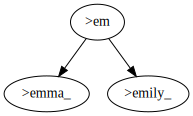

In [1]:
from src.plastic_prefix_network import PlasticPrefixNetwork
constructor = PlasticPrefixNetwork()

samples = ["emily", "emma"]

# padding with start and end tokens
tokenized_samples = [">" + x + "_" for x in samples]

for item in tokenized_samples:
    constructor.learn(item)

constructor.visualize()


Let's teach it a few more names:

LEARNING:  >rohan_
PREFIX COUNT :  {'>': {'count': 2, 'matches': ['>emily_', '>emma_']}}
CHECKING :  >
one level down does exist, hence finding out if should insert there or not
CHECKING :  >
one level down doesn't exist, hence inserting at one level down.
insert >  at r_level -1 ...
adding node :  >  with data  {'count': 1, 'r_level': -1}
adding node :  >rohan_  with data  {'count': 0, 'r_level': 0}
adding edge :  >  ->  >rohan_  with data  {}
adding edge :  >  ->  >em  with data  {}
LIFTING R at:  >
LIFTING R at:  >rohan_
LIFTING R at:  >em
LIFTING R at:  >emma_
LIFTING R at:  >emily_
POTENTIATING at:  >rohan_
POTENTIATING at:  >
---END---
LEARNING:  >rehan_
PREFIX COUNT :  {'>': {'count': 2, 'matches': ['>emily_', '>emma_']}}
CHECKING :  >
one level down does exist, hence finding out if should insert there or not
CHECKING :  >r
one level down does exist, hence finding out if should insert there or not
insert >r  at r_level 0 ...
removing edge :  >  ->  >rohan_
adding node :  >r  wit

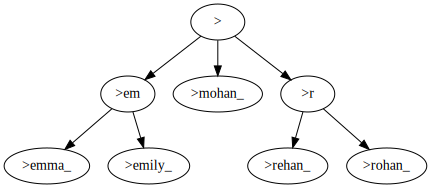

In [2]:
samples = ["rohan", "rehan", "mohan"]

tokenized_samples = [">" + x + "_" for x in samples]

for item in tokenized_samples:
    constructor.learn(item)

constructor.visualize()

#### Refactoring Levels (`r_level`)

The learning algorithm ensures that each level in this hierarchy contains non-intersecting patterns / strings, that can be used to _refactor_ the samples in level above (and the entire dataset as a whole). We call this level refactoring levels, or `r_level`s. We can visualize the `r_level` for each node in the tree below switching that flag to `True` `(rN)`.

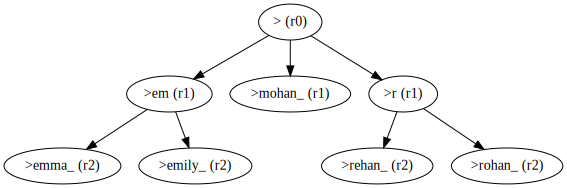

In [3]:
constructor.visualize(with_r_levels=True)

Apart from the r_levels, each node also has count information about how many times that pattern occurs in the entire dataset `(cN)`. Visualized below.

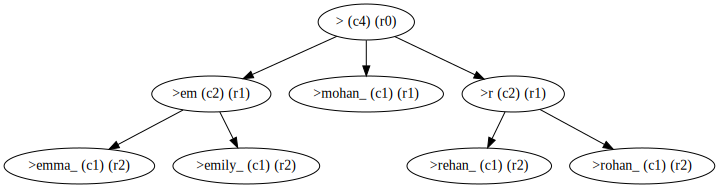

In [4]:
constructor.visualize(with_counts=True, with_r_levels=True)

We can next run an inference to see that a tree with these two pieces of information for each node is all that is needed to run a a Markovian inference.

REFACTORINGS:
STEP 0  --  >r
FOUND!  1 ['>em', '>r', '>mohan_'] >r
FIRST R LEVEL:  ['>em', '>r', '>mohan_']
STEP 1  --  >r
EXACT MATCH FOUND. FORWARDING.
STEP 2  --  >r
DESCENDANT: >rehan_
DESCENDANT: >rohan_
Current inference string:  >r


/Users/sibeshkar/Maya/ml/repositories/plastic-memory/src/utils.py:7: RuntimeWarning: invalid value encountered in divide
  a_norm = np.nan_to_num((arr/arr.sum(axis=1)[:,None]).round(7))


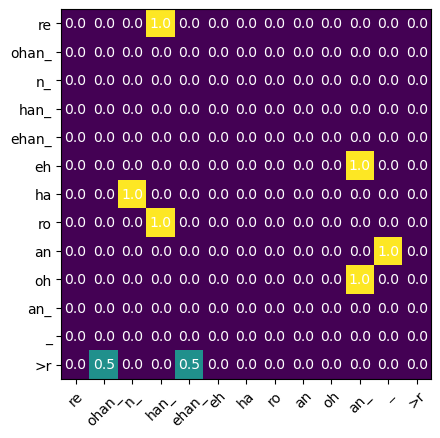

NEXT STRING PROBABILITIES: {'ohan_': 0.5, 'ehan_': 0.5}
Selecting :  ehan_  with p  0.5
Next inference string: >rehan_
END RESULT:  >rehan_


In [5]:
constructor.infer(">r", stop_token="_")

## Potentiation

With the previous inference, we see that it gives the same _p-value_ 0.5 (or probability) for both `ehan_` and `ohan_` in the last step. Which means both have the same 50% chance of being predicted. Say we want to bias it to produce `>rohan_` when provided the starting string `>r`. This can be done with just a single extra sample.

In [6]:
constructor.learn(">rohan")

LEARNING:  >rohan
PREFIX COUNT :  {'>': {'count': 2, 'matches': ['>emily_', '>emma_']}, '>rohan': {'count': 1, 'matches': ['>rohan_']}, '>r': {'count': 1, 'matches': ['>rehan_']}}
CHECKING :  >rohan
one level down does exist, hence finding out if should insert there or not
insert >rohan  at r_level 1 ...
removing edge :  >r  ->  >rohan_
adding node :  >rohan  with data  {'count': 1, 'r_level': 1}
adding node :  >rohan  with data  {'count': 0, 'r_level': 2}
adding edge :  >rohan  ->  >rohan  with data  {}
adding edge :  >rohan  ->  >rohan_  with data  {}
adding edge :  >r  ->  >rohan  with data  {}
LIFTING R at:  >rohan
LIFTING R at:  >rohan_
POTENTIATING at:  >rohan
POTENTIATING at:  >r
POTENTIATING at:  >
---END---


As seen below, the count of the string `>rohan` got implemented by +1 to `(c2)`. but all it's ancestor dependencencies also got incremented by +1. A `potentiation signal` was fired from `>rohan` down. This is a localized signal that travels from node-to-incoming-node. `>rohan_` tells `>rohan` to increment count, which tells `>r` which tells `>`. In this way, a new piece of info added to the top of the tree is propagated to the entire tree, because of the hierarchical way in which info is arranged.

In such a way, the plastic memory can display continual long-term learning, without needing to be retrained from scratch. In the future a negative -1 signal could be potentiated across the tree to strengthen/weak some abstraction.

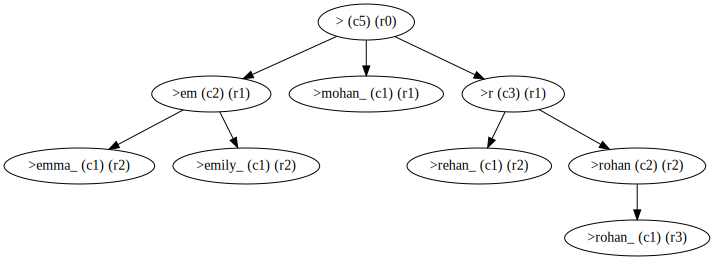

In [7]:
constructor.visualize(with_counts=True, with_r_levels=True)

In addition to the count increment, the `r_level` of `>rohan` also got incremented to `(r3)`. This happened when the new abstraction `>rohan` was added at `(r1)`, connected to `>rohan` at `(r2)`, and a reverse lift potentiation fired from `>rohan` down the tree (node-to-outgoing-node) from the new abstraction to increment `r_level`. 

## Scaling up

### Learning 40 common first names

Running the following will create a constructor and open windows visualizing the potentiations step-by-step.

learning word 0/40...
LEARNING:  >emma_
---END---
learning word 1/40...
LEARNING:  >olivia_
PREFIX COUNT :  {'>': {'count': 1, 'matches': ['>emma_']}}
CHECKING :  >
one level down doesn't exist, hence inserting at one level down.
insert >  at r_level -1 ...
adding node :  >  with data  {'count': 1, 'r_level': -1}
adding node :  >olivia_  with data  {'count': 0, 'r_level': 0}
adding edge :  >  ->  >olivia_  with data  {}
adding edge :  >  ->  >emma_  with data  {}
LIFTING R at:  >
LIFTING R at:  >olivia_
LIFTING R at:  >emma_
POTENTIATING at:  >olivia_
POTENTIATING at:  >
---END---
learning word 2/40...
LEARNING:  >ava_
PREFIX COUNT :  {'>': {'count': 2, 'matches': ['>emma_', '>olivia_']}}
CHECKING :  >
one level down does exist, hence finding out if should insert there or not
insert >  at r_level 0 ...
removing edge :  >  ->  >olivia_
removing edge :  >  ->  >emma_
adding node :  >  with data  {'count': 1, 'r_level': 0}
adding node :  >ava_  with data  {'count': 0, 'r_level': 1}
adding

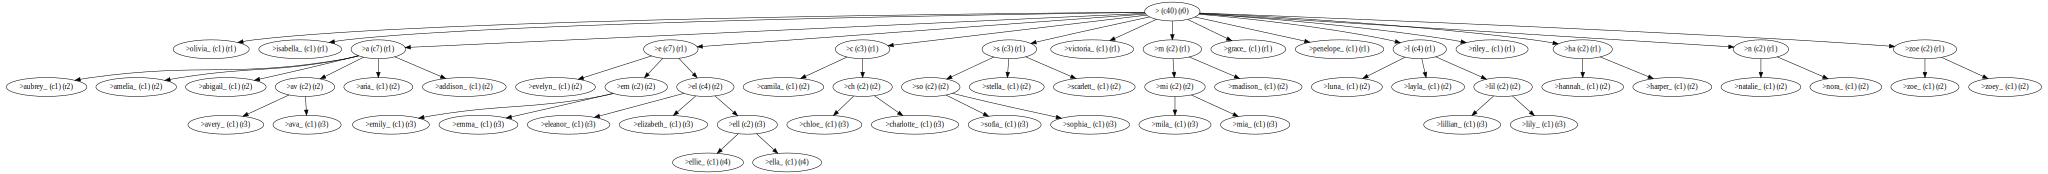

In [8]:
constructor_mid = PlasticPrefixNetwork()
words = open("names.txt", "r").read().splitlines()[:40]
samples = [">" + x + "_" for x in words]
for i, word in enumerate(samples):
    print(f"learning word {i}/{len(samples)}...")
    constructor_mid.learn(word)
constructor_mid.visualize(with_counts=True, with_r_levels=True)

If you don't have graphviz to visualize the above, here's a demo : https://www.youtube.com/watch?v=OOYJupTzCLI

### Note the following : 
1. Blue signals : the count potentiations that serve to increment `count` node-by-node
2. Green signals : the r_level potentiations that serve to increment `r_level` node-by-node

## Learning 32,000 common first names

This creates ~42k nodes and takes ~2mins to train. 

In [ ]:
constructor_large = PlasticPrefixNetwork()
words = open("names.txt", "r").read().splitlines()[:32000]
samples = [">" + x + "_" for x in words]
for i, word in enumerate(samples):
    print(f"learning word {i}/{len(samples)}...")
    constructor_large.learn(word)

This is hard to visualize using `graphviz` since it has ~42,000 nodes. You can dump the `edge` and `node` data into `.csv` files, and visualize it using the browser-based WebGL GPU-optimized tool Cosmograph https://cosmograph.app/run/. Demo : https://www.youtube.com/watch?v=ONSVN4-Hua0

In [10]:
constructor_large.format_and_write_csv()

Writing complete:  edges.csv
Writing complete:  nodes.csv
